# Continual learning

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one. We want to observe the catastrophic forgetting phenomenon. In our case, when performance increase on FashionMNIST, it decreases on MNIST.

In [3]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss

In [4]:
subsample = 10_000
batch_size = 128
mnist_epochs = 15
fashion_epochs = 15
mnist = True
fashion = True

In [5]:
# import MNIST
train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
mnist_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [6]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 12 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # convolutions
        x = self.conv1(x)
        x = self.max_pool(self.conv2(x))
        # classifier
        x = x.view(-1, 12 * 12 * 32)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        return torch.softmax(self.fc2(x), dim=1)

In [8]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("MNIST - F1 score", f1_score(y_test, y_pred, average="macro"))
    return f1_score(y_test, y_pred, average="macro")

In [9]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("Fashion - F1 score", f1_score(y_test, y_pred, average="macro"))
    return f1_score(y_test, y_pred, average="macro")

In [10]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_scores = []
fashion_scores = []
fashion_losses = []

# MNIST
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

# FashionMNIST
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        fashion_losses.append(loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- MNIST ---
Epoch 0 - loss 1.5529237985610962
Epoch 1 - loss 1.5039383172988892
Epoch 2 - loss 1.4840697050094604
Epoch 3 - loss 1.4821335077285767
Epoch 4 - loss 1.4727483987808228
Epoch 5 - loss 1.490480899810791
Epoch 6 - loss 1.4763692617416382
Epoch 7 - loss 1.488587498664856
Epoch 8 - loss 1.476400375366211
Epoch 9 - loss 1.4866799116134644
Epoch 10 - loss 1.4740585088729858
Epoch 11 - loss 1.4718183279037476
Epoch 12 - loss 1.4672874212265015
Epoch 13 - loss 1.4924005270004272
Epoch 14 - loss 1.4715666770935059
--- Scores ---
Fashion - F1 score 0.06830910735575352
MNIST - F1 score 0.9817405759046226
--- FashionMNIST ---
Epoch 0 - loss 1.8580797910690308
Epoch 1 - loss 1.773503303527832
Epoch 2 - loss 1.6689720153808594
Epoch 3 - loss 1.74348783493042
Epoch 4 - loss 1.6978729963302612
Epoch 5 - loss 1.7736049890518188
Epoch 6 - loss 1.7111304998397827
Epoch 7 - loss 1.7230547666549683
Epoch 8 - loss 1.7129602432250977
Epoch 9 - loss 1.7930026054382324
Epoch 10 - loss 1.74255049

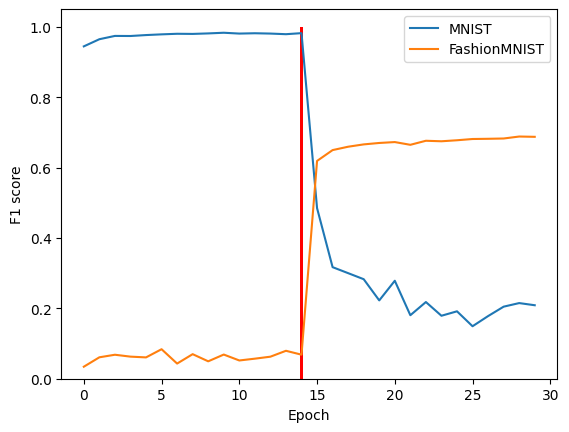

In [16]:
plt.figure()
plt.plot(mnist_scores, label="MNIST")
plt.plot(fashion_scores, label="FashionMNIST")
plt.bar(mnist_epochs - 1, height=1, width=0.2, color="r")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()
plt.savefig("results_cnn.png")
plt.show()